In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import numpy as np 
import plotly.express as px
import matplotlib.pyplot as plt
# load utils
import utils as ut
pd.set_option('display.max.columns', 100)

factorsModel = ['trees', 'depth']


Carga de archivos de los resultados, los resultados estan desagregados, entre drop3 y entropy.

In [2]:
def compute_metrics (row):
    #print(df)
    row['wtdAcc'] = 0.7*row['sensibility'] + 0.3*row['specificity']
    row['balancedAcc'] = (row['sensibility'] + row['specificity'])/2
    mcc_den = (row.tp+row.fp) * (row.tp + row.fn) * (row.tn+row.fp) * (row.tn+row.fn)
    #print(mcc_den)
    row['mcc'] = ((row.tp*row.tn) - (row.fp*row.fn))/ np.sqrt( float(mcc_den) )
    return (row)

In [3]:
# filter out the no instance selection and drop3
# carga de dataframe para entropy
entropy_results_ori = ut.read_results("./data/is_experiments",  ["susyAllResults.csv"])
condition = (entropy_results_ori.isMethod != 'drop3') & (entropy_results_ori.instanceSelection != 'NOIS')
no_is_results =  entropy_results_ori[entropy_results_ori.instanceSelection == 'NOIS'].copy().reset_index(drop= True)
entropy_results = entropy_results_ori[condition].copy().reset_index(drop= True)

entropy_results = entropy_results.apply(compute_metrics , axis = 1)
no_is_results = no_is_results.apply(compute_metrics , axis = 1)

--- 
para adaptar los resultados de rf puro

In [4]:
# resultados de rf
# we need to keep only best parameters
# of trees and depth, for each type (train-test)
rf_p2p = pd.read_csv("data/results_no_is/confusionAll.csv")
rf_p2p['counts'] = rf_p2p.groupby(['tipo',
                'trees',
                'impurity', 
                'depth', 'bins'])['tp'].transform('count')
rf_p2p = rf_p2p[rf_p2p['counts']==5].drop('counts', axis = 1)

In [5]:
rf_p2p.trees.unique()

array([  2,  10,  50, 100])

In [6]:
rf_p2p['k'] = rf_p2p.groupby([ 'trees', 'depth',  'impurity', 'bins', 'tipo'])['F1'].transform('rank')
rf_p2p = rf_p2p#[rf_p2p.k<=5]
print(rf_p2p.tipo.unique())
rf_p2p = rf_p2p.sort_values(['F1', 'trees', 'depth', 'tipo', 'k'], ascending = False).drop_duplicates(['trees', 'depth', 'tipo','k'])
print(rf_p2p.tipo.unique())
rf_p2p = rf_p2p.drop(['bins', 'impurity', 'PEXC', 'MCC'], axis =1).reset_index(drop = True)
print(rf_p2p.columns)
rf_p2p.columns = ['type', 'tp', 'fn', 'tn', 'fp', 'sensibility', 'specificity', 'precision', 'accuracy', 'F1', 'Gmean', 'AreaROC', 'trees', 'depth', 'k']
print(rf_p2p.type.unique())
rf_p2p_final = rf_p2p.copy().apply(lambda row : compute_metrics(row) , axis = 1)
rf_p2p_final['database'] = 'p2p'
print(rf_p2p_final.type.unique())

['test' 'train']
['train' 'test']
Index(['tipo', 'tp', 'fn', 'tn', 'fp', 'TPR', 'SPC', 'PPV', 'ACC', 'F1',
       'MGEO', 'areaRoc', 'trees', 'depth', 'k'],
      dtype='object')
['train' 'test']
['train' 'test']


In [7]:
ignore_cols = [] # ['subBuckets', 'buckAvg', 'reduction', 'buckets', 'buckMax', 'buckMin', 'timeIS', 'timeLSH']
#missing_columns = (set(no_is_results.columns) - set(rf_p2p_final.columns)) - set(ignore_cols)
missing_columns =  ['ands', 'lshMEthod', 'isMethod', 'instanceSelection', 'imbalance', 'ors']
print("missing", missing_columns)
cols_to_complete = no_is_results[missing_columns].copy().drop_duplicates(
    ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'instanceSelection']).reset_index(drop = True)
cols_to_complete['aux'] = 1
rf_p2p_final['aux'] = 1
rf_p2p_final = pd.merge(cols_to_complete, rf_p2p_final, how = 'left', on = 'aux').drop('aux', axis = 1)

missing ['ands', 'lshMEthod', 'isMethod', 'instanceSelection', 'imbalance', 'ors']


In [8]:
rf_p2p_final.groupby(factorsModel)['tp'].count()

trees  depth
2      10       240
       20       180
       30       240
10     10       180
       20       180
       30       210
50     10       240
       20       210
       30       210
100    10       270
       20       240
       30       210
Name: tp, dtype: int64

In [9]:
no_is_results['type'] = no_is_results['type'].str.lower()
no_is_results = pd.concat([no_is_results[rf_p2p_final.columns], rf_p2p_final[rf_p2p_final.columns]], ignore_index=True)


---


Ahora todos los resultados de drop3

In [10]:
# filter out the no instance selection and drop3
# carga de dataframe para entropy
drop3_files = ['boundaries.csv', "one.csv", "test.csv"]
drop3_results = ut.read_results("./data/drop3",  drop3_files)
condition = (drop3_results.isMethod == 'drop3') & (drop3_results.instanceSelection != 'NOIS')
drop3_results = drop3_results[condition].copy().reset_index(drop= True)
# in the drop3 the file have the db and the
# one sample bucket
drop3_results = drop3_results.apply(compute_metrics , axis = 1)
drop3_results[['database', 'one_class_method']] = drop3_results.database.str.replace(".csv", "").str.split("_", expand = True)

Now We will concatenate the results



In [11]:
entropy_results['one_class_method'] = 'entropy'
drop3_entropy = pd.concat([entropy_results, drop3_results], ignore_index=True)
# deduplicate records
drop3_entropy = drop3_entropy.drop_duplicates()

In [12]:
## add axiliary results        
drop3_entropy['Total Time'] = drop3_entropy.timeLSH + drop3_entropy.timeIS
drop3_entropy['total'] = drop3_entropy.tp + drop3_entropy.tn + drop3_entropy.fn + drop3_entropy.fp
drop3_entropy['samples by bucket average (relative)'] = drop3_entropy.buckAvg/drop3_entropy.total*100.0
drop3_entropy['model_complexity'] =  drop3_entropy.trees*drop3_entropy.depth
drop3_entropy['Reduction of DataSet(%)'] = (1 - drop3_entropy['reduction'])*100.0
drop3_entropy['type'] = drop3_entropy['type'].str.lower()

# Adapt the dataframes to plots

In [13]:
cols_to_dedup = ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'database', 'k', 'type', 'instanceSelection'] + factorsModel

In [14]:
measuresNoIS = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 
                'accuracy', 'F1', 'Gmean', 'wtdAcc','AreaROC', 'balancedAcc', 'mcc']
factorsNoIS = ['database']
cols_to_dedup_noIs = ['ands', 'database', 'k', 'type'] +factorsModel

no_is_results_dp =  no_is_results.drop_duplicates(cols_to_dedup_noIs)
best_no_is = (no_is_results_dp.groupby(factorsNoIS)
                .apply(lambda g : ut.get_best_for(g, measuresNoIS, measure_sort = 'Gmean', factorsModel = factorsModel, debug = False, agg=False))
                .reset_index())


best_no_is['model_complexity'] =  best_no_is.trees*best_no_is.depth

In [15]:
 best_no_is['k']= best_no_is.groupby(['tp', 'database', 'type', 'trees', 'depth']).cumcount()+1

In [16]:
best_no_is = best_no_is[best_no_is['k']==1]

In [17]:
ands = no_is_results.ands.unique()
dfs = []
for a in ands:
    df_partial = best_no_is.copy()
    df_partial['ands'] = a
    dfs.append(df_partial)
best_no_is = pd.concat(dfs, ignore_index=True)

In [18]:
drop3_entropy.drop_duplicates(cols_to_dedup).groupby(['database', 
                        'instanceSelection',
                        'imbalance', 
                        'lshMEthod']+ factorsModel)['tp'].count()

database    instanceSelection  imbalance  lshMEthod    trees  depth
fraudk      IS                 False      hyperplanes  10     10        50
                                                              20        50
                                                              30        50
                                                       25     10        50
                                                              20        50
                                                                      ... 
pageblocks  IS                 True       projection   25     20       100
                                                              30       100
                                                       50     10       100
                                                              20       100
                                                              30       100
Name: tp, Length: 162, dtype: int64

In [20]:
drop3_entropy[drop3_entropy.imbalance==True].drop_duplicates(cols_to_dedup +[ 'one_class_method']).groupby(['database', 
                        'instanceSelection',
                        'one_class_method',
                        'lshMEthod']).agg({'tp': 'count', 'ands': 'unique', 'k': 'unique', 'trees': 'unique', 'depth': 'unique'})

tp  \
database   instanceSelection one_class_method lshMEthod                     
fraudk     IS                boundaries       hyperplanes             450   
                                              hyperplanes-projection  450   
                                              projection              450   
                             entropy          hyperplanes             450   
                                              hyperplanes-projection  450   
                                              projection              450   
                             one              hyperplanes             450   
                                              hyperplanes-projection  450   
                                              projection              450   
p2p        IS                boundaries       hyperplanes             202   
                                              hyperplanes-projection  182   
                                              projection              180   
                             entropy          hyperplanes             450   
                                              hyperplanes-projection  450   
                                              projection              450   
                             one              hyperplanes             322   
                                              hyperplanes-projection  300   
                                              projection              288   
pageblocks IS                boundaries       hyperplanes             450   
                                              hyperplanes-projection  450   
                                              projection              450   
                             entropy          hyperplanes             450   
                                              hyperplanes-projection  450   
                                              projection              450   
                             one              hyperplanes             450   
                                              hyperplanes-projection  450   
                                              projection              450   

                                                                                  ands  \
database   instanceSelection one_class_method lshMEthod                                  
fraudk     IS                boundaries       hyperplanes             [6, 8, 10, 2, 4]   
                                              hyperplanes-projection  [6, 8, 10, 2, 4]   
                                              projection              [6, 8, 10, 2, 4]   
                             entropy          hyperplanes             [2, 4, 6, 8, 10]   
                                              hyperplanes-projection  [2, 4, 6, 8, 10]   
                                              projection              [2, 4, 6, 8, 10]   
                             one              hyperplanes             [2, 4, 6, 8, 10]   
                                              hyperplanes-projection  [2, 4, 6, 8, 10]   
                                              projection              [2, 4, 6, 8, 10]   
p2p        IS                boundaries       hyperplanes             [6, 2, 4, 8, 10]   
                                              hyperplanes-projection  [2, 4, 6, 8, 10]   
                                              projection              [2, 4, 6, 8, 10]   
                             entropy          hyperplanes             [2, 4, 6, 8, 10]   
                                              hyperplanes-projection  [2, 4, 6, 8, 10]   
                                              projection              [2, 4, 6, 8, 10]   
                             one              hyperplanes             [2, 4, 6, 8, 10]   
                                              hyperplanes-projection  [2, 4, 6, 8, 10]   
                                              projection              [2, 4, 6, 8, 10]   
pageblocks IS                boundari

In [21]:
factorsIS = ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'database', 'one_class_method']

measures = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 'accuracy', 'F1', 
'Gmean','wtdAcc', 'balancedAcc', 'mcc','AreaROC', 'timeIS', 'timeLSH', 'model_complexity', 'Total Time', 'Reduction of DataSet(%)']

In [26]:
drop3_entropy.one_class_method.unique()

array(['entropy', 'boundaries', 'one'], dtype=object)

In [30]:
## correct some values names
def adjust_names (value, fix):
    return (fix[value])

drop3_entropy['database']= drop3_entropy.database.apply(adjust_names, fix={'fraudk': 'credit_card', 'p2p':'gateway_credit_card', 'pageblocks': 'pageblocks'})
drop3_entropy.one_class_method = drop3_entropy.one_class_method.apply(adjust_names, fix={'entropy': 'entropy', 'boundaries':'drop3-boundaries', 'one': 'drop3-one'})

In [38]:
best_no_is['database']= best_no_is.database.apply(adjust_names, fix={'fraudk': 'credit_card', 'p2p':'gateway_credit_card', 'pageblocks': 'pageblocks'})

## the actual plots

In [48]:
def plot_9_results (df_in, df_reference, measure = 'Gmean', measure_for_best = 'Gmean', aspect=2, height=8):

    linewidth =  6
    
    gg = sns.relplot(data = df_in[df_in.type=='test'], x ='ands', 
                y= measure, 
                style = 'lshMEthod', 
                hue = 'lshMEthod', 
                col = 'db/IS_Method',
                col_wrap=3,
                kind = 'line', 
                aspect = aspect,
                height=height,
                facet_kws = {'sharey': 'row'},
                linewidth =linewidth,
                err_style =  'bars',  legend = 'full')
    
    leg = gg._legend
    
    g = sns.relplot(data = df_in[df_in.type=='test'], x ='ands', 
                y= measure, 
                style = 'lshMEthod', 
                hue = 'lshMEthod', 
                col = 'db/IS_Method',
                col_wrap=3,
                kind = 'line', 
                aspect = aspect,
                height=height,
                facet_kws = {'sharey': 'row'},
                linewidth =linewidth,
                err_style =  'bars',  legend = False)
    
    if df_reference is not None:
        # add reference
        axs  = np.ravel (g.axes)
        for ax in np.ravel(axs):
            db = ut.get_db_from_ax(ax).split("/")[0]
            mea_test = df_reference.loc[(df_reference.database==db) & (df_reference.type == 'test'), ['ands', measure]].copy()
            mea_test['reference'] = 'reference'
            if len(mea_test) > 0:
                xx = sns.lineplot(x="ands", 
                                y=measure, data=mea_test,
                                ax = ax, 
                                palette = sns.color_palette("gist_gray", n_colors=1), 
                                legend = False, 
                                linewidth =5,
                                err_style =  'bars', 
                                hue = 'reference')
        ## current labels and adding the reference
        #leg = g._legend
        #leg.set_visible(False)
        current_labels = [label.get_text() for label in leg.texts] + ['reference']
        current_handlers = leg.legendHandles + [ax.lines[-2]]
        dict_legend = {label: handler for label,handler in zip (current_labels, current_handlers) }
        g.fig.subplots_adjust(wspace=0.1, hspace=0.1, top = 1.0 )
        #(x, y, width, height)
        g.add_legend(dict_legend, bbox_to_anchor=(0.05, 1.1,1.0, 0.0), loc='upper left',
           ncol=5, mode=None, borderaxespad=0.5, fontsize = 28, borderpad = 0.8)
        for line in g._legend.get_lines():
            line.set_linewidth(7.0)    
    # save figure
    g.savefig(f"report/{measure}.png", dpi = 300,  bbox_inches='tight',  bbox_extra_artists=(g._legend,))
    #plt.show()
    return(g, dict_legend)

In [49]:
results_dedup = drop3_entropy.drop_duplicates(cols_to_dedup +[ 'one_class_method'])
cond= results_dedup.imbalance == True
df_toplot = (results_dedup[cond].groupby(factorsIS)
                .apply(lambda g : ut.get_best_for(g, measures, measure_sort = 'Gmean', factorsModel = factorsModel))
                .reset_index())
df_toplot['db/IS_Method'] = df_toplot.database + "/" +  df_toplot.one_class_method

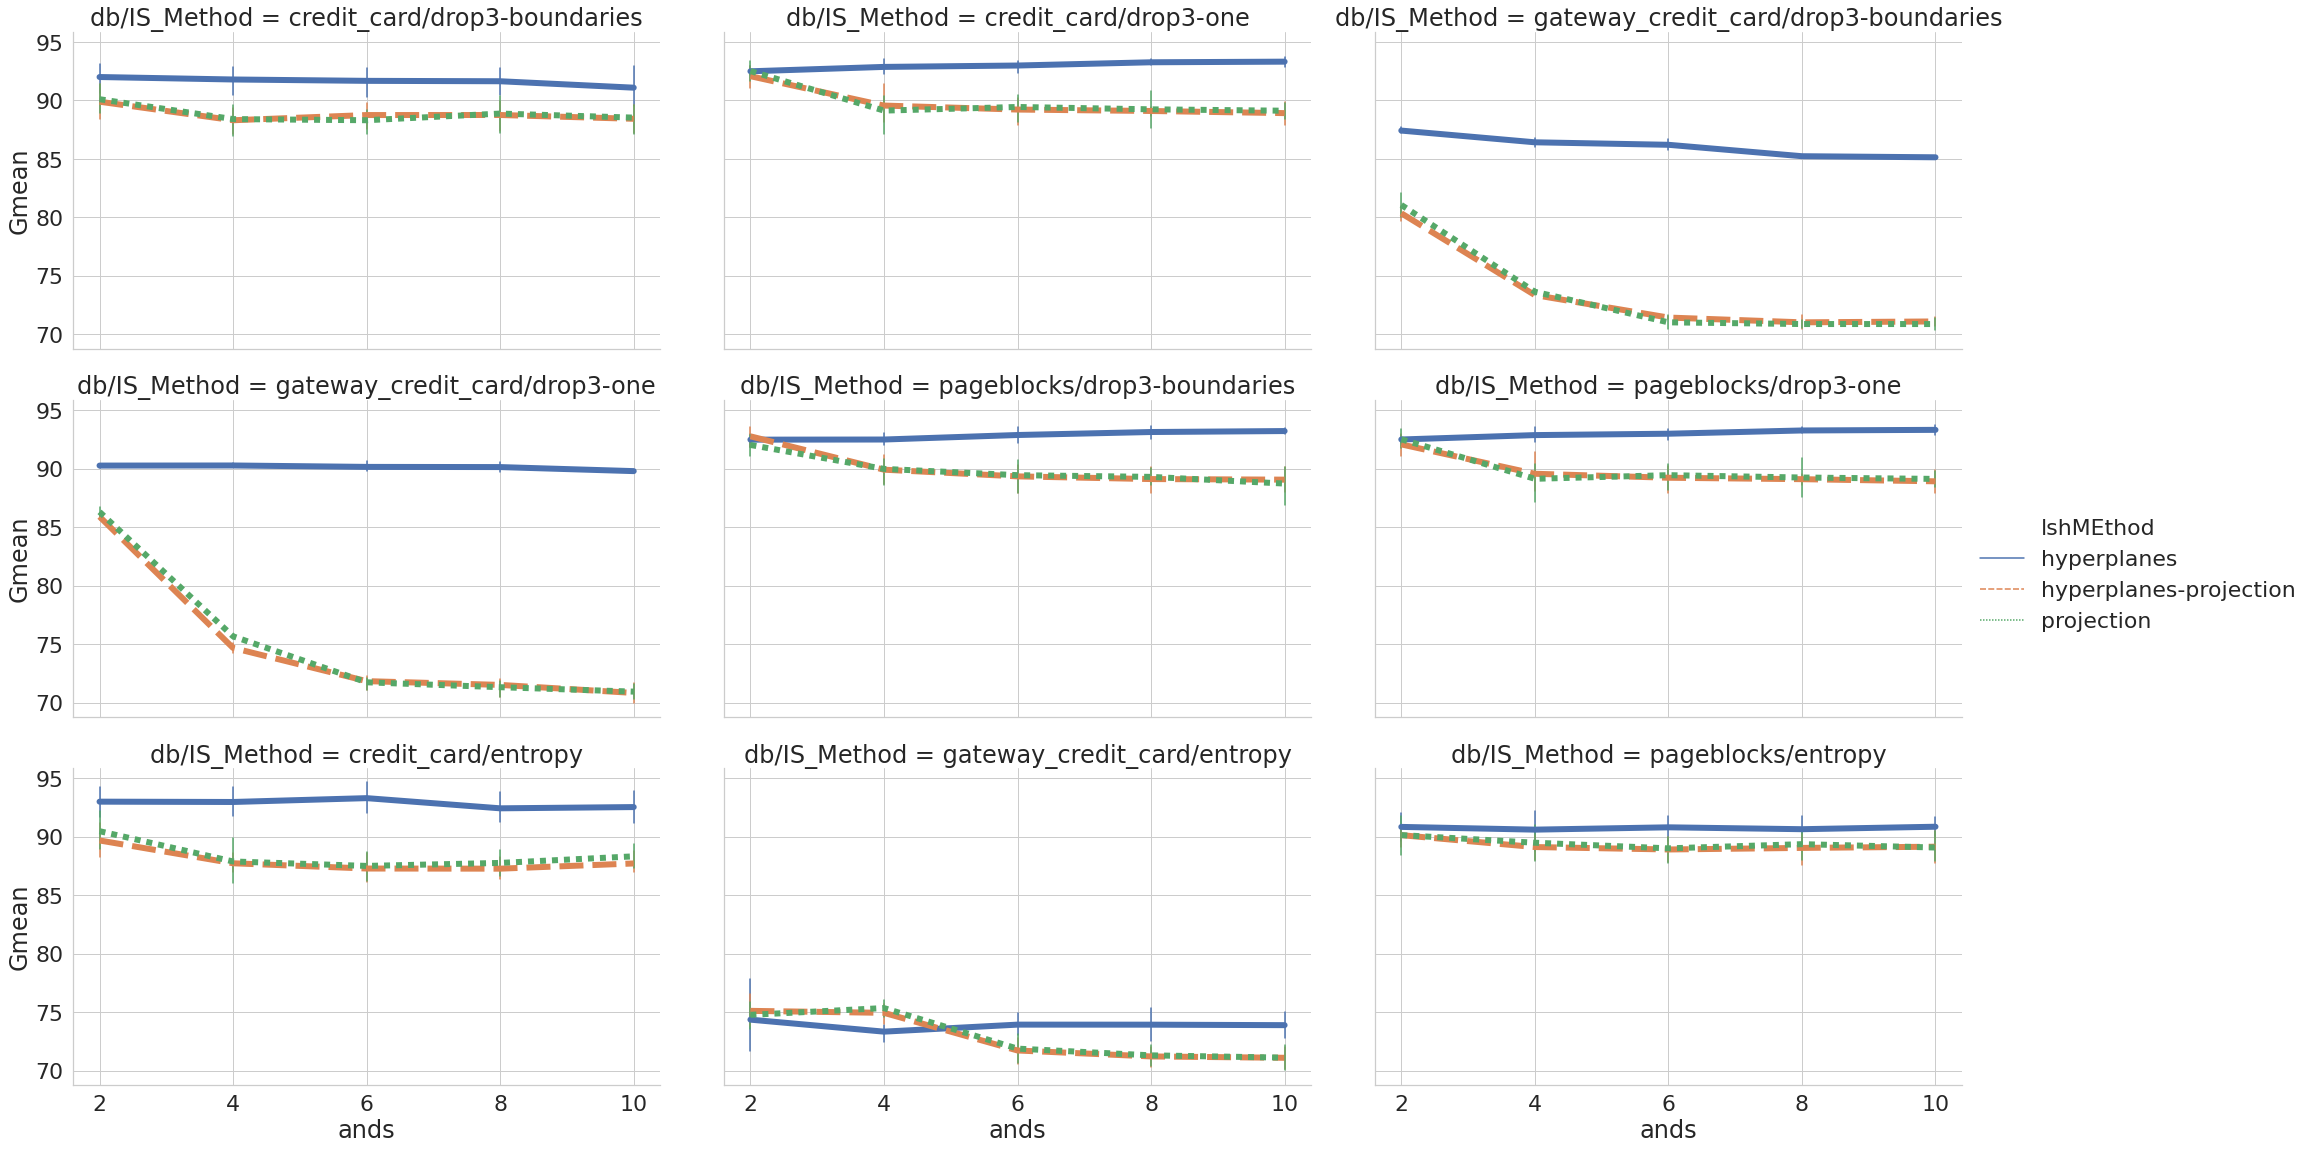

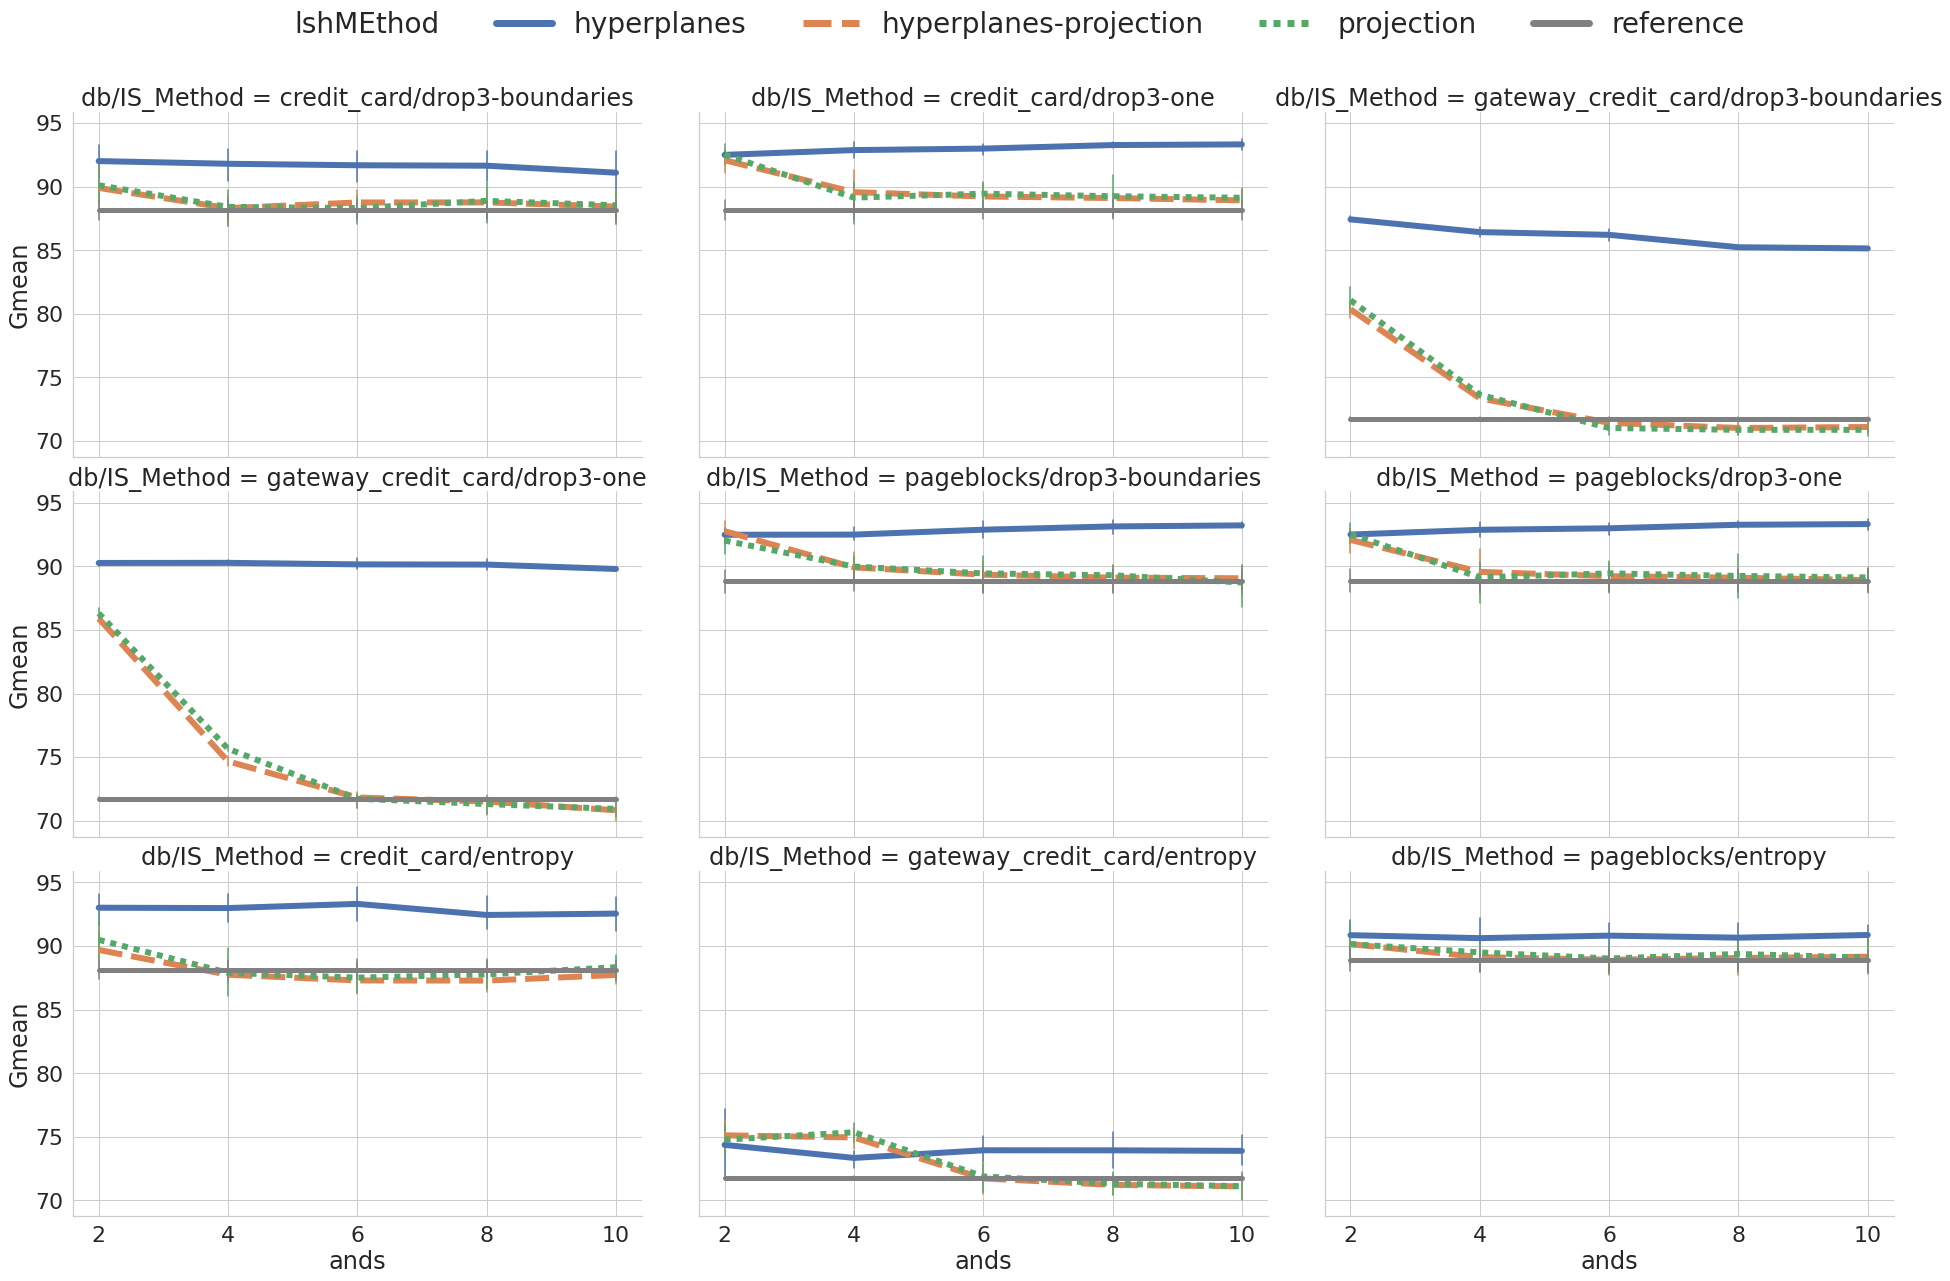

In [50]:
sns.set(font_scale=2, style='whitegrid')
gg,ll = plot_9_results(df_toplot, best_no_is, measure= 'Gmean', measure_for_best='Gmean', aspect =1.7, height=5.5)

(<seaborn.axisgrid.FacetGrid at 0x7f5b512735f8>,
 {'lshMEthod': <matplotlib.lines.Line2D at 0x7f5b4e20fa90>,
  'hyperplanes': <matplotlib.lines.Line2D at 0x7f5b4e20f6a0>,
  'hyperplanes-projection': <matplotlib.lines.Line2D at 0x7f5b4e20b4e0>,
  'projection': <matplotlib.lines.Line2D at 0x7f5b4e20b048>,
  'reference': <matplotlib.lines.Line2D at 0x7f5b50c41390>})

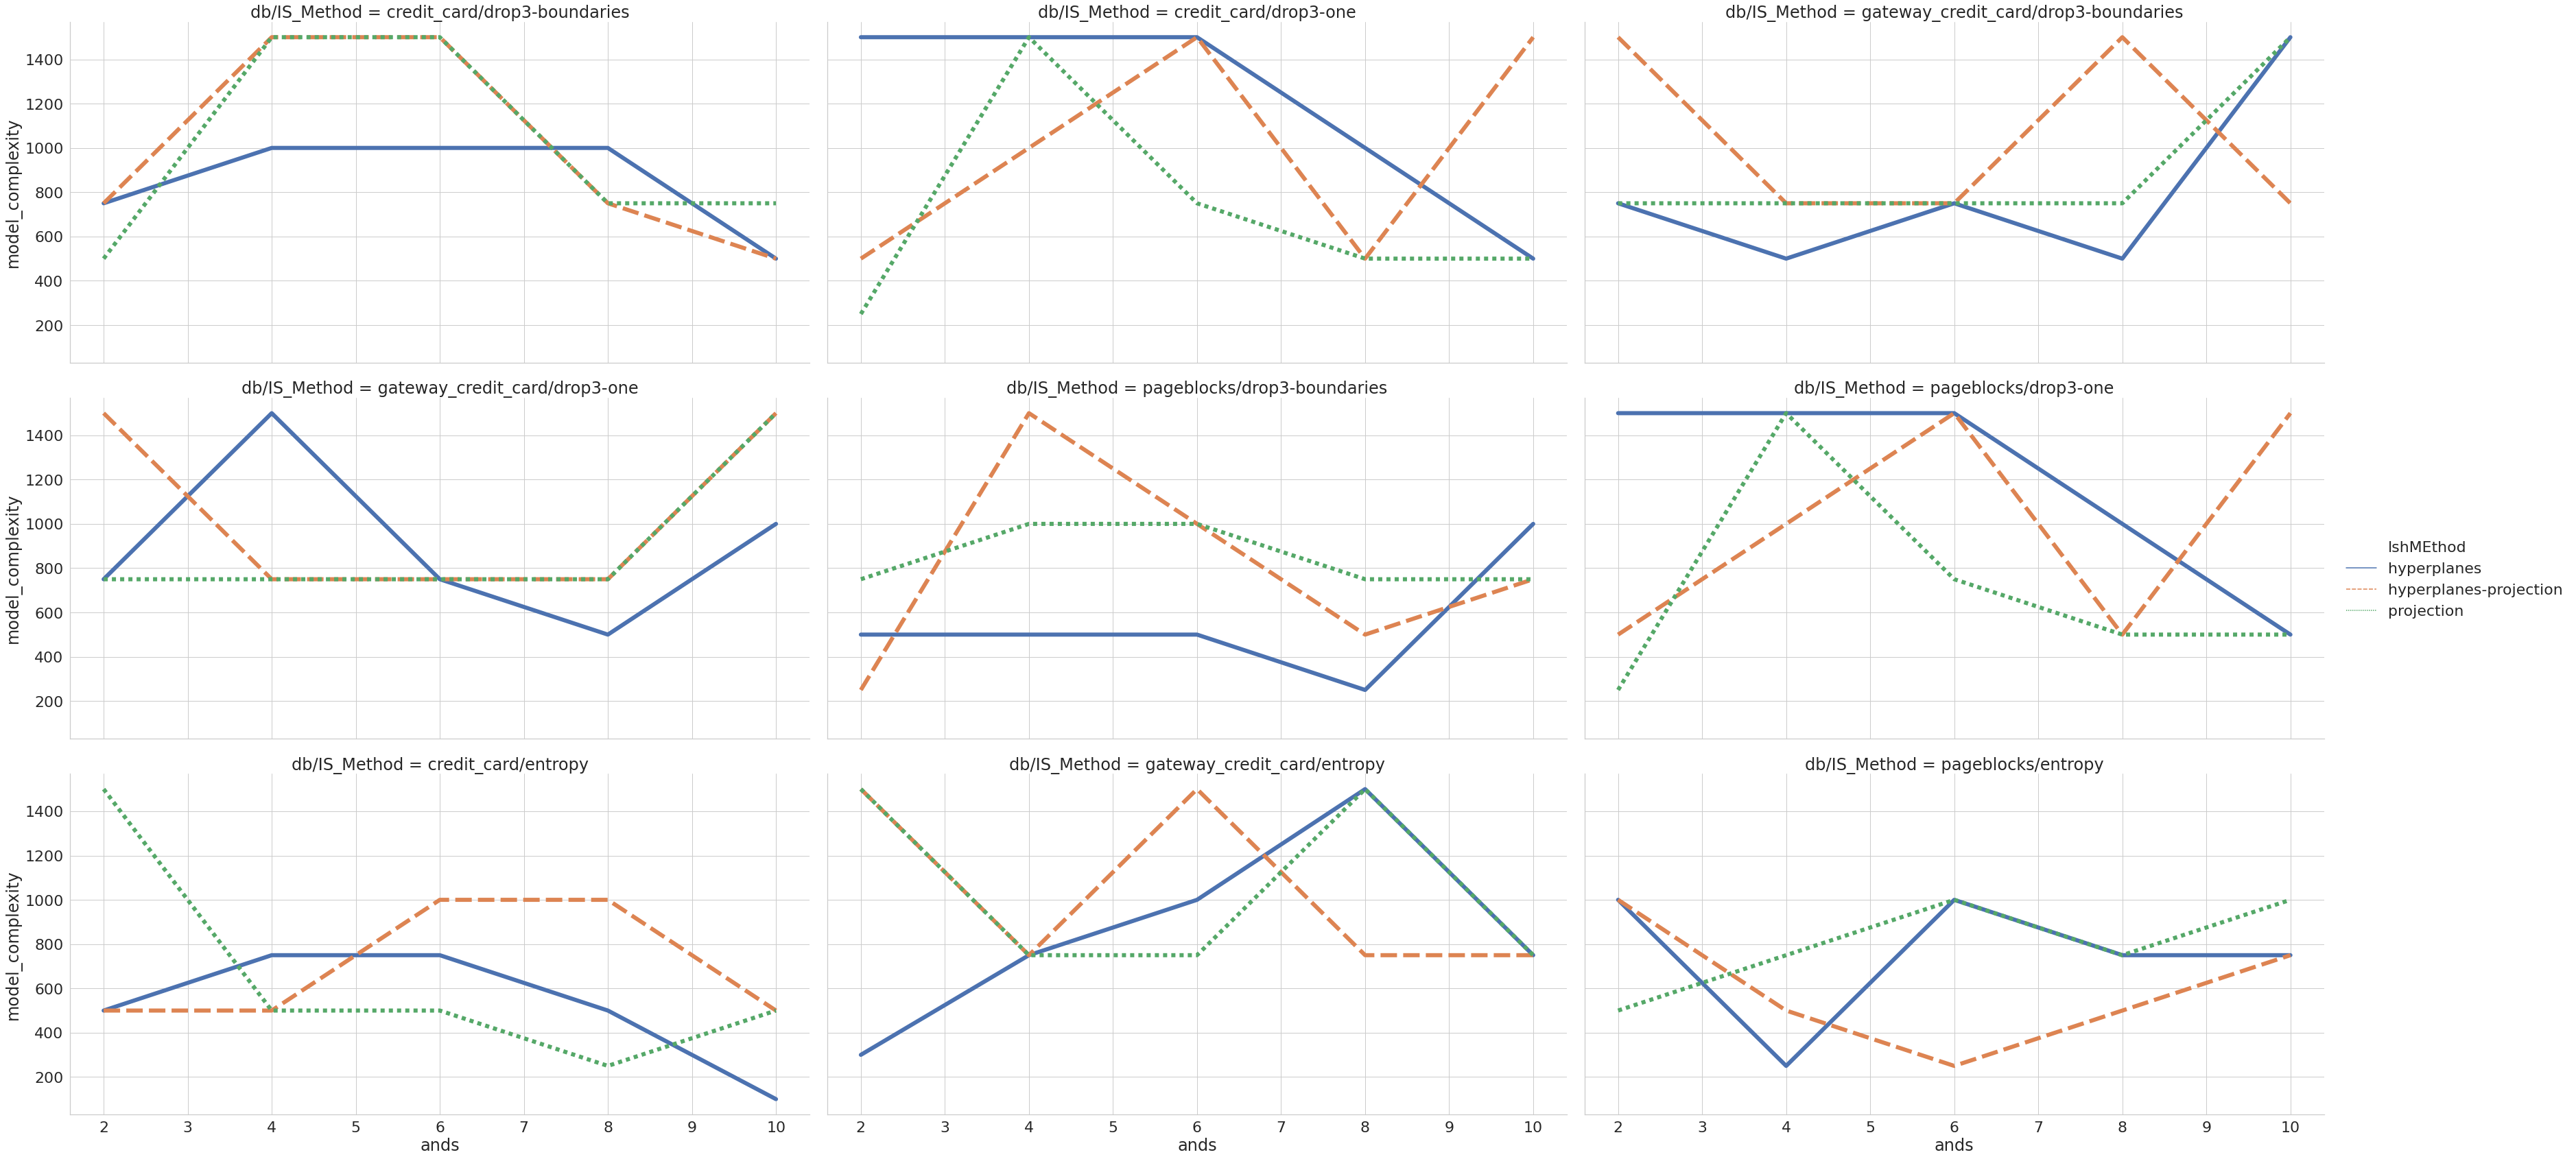

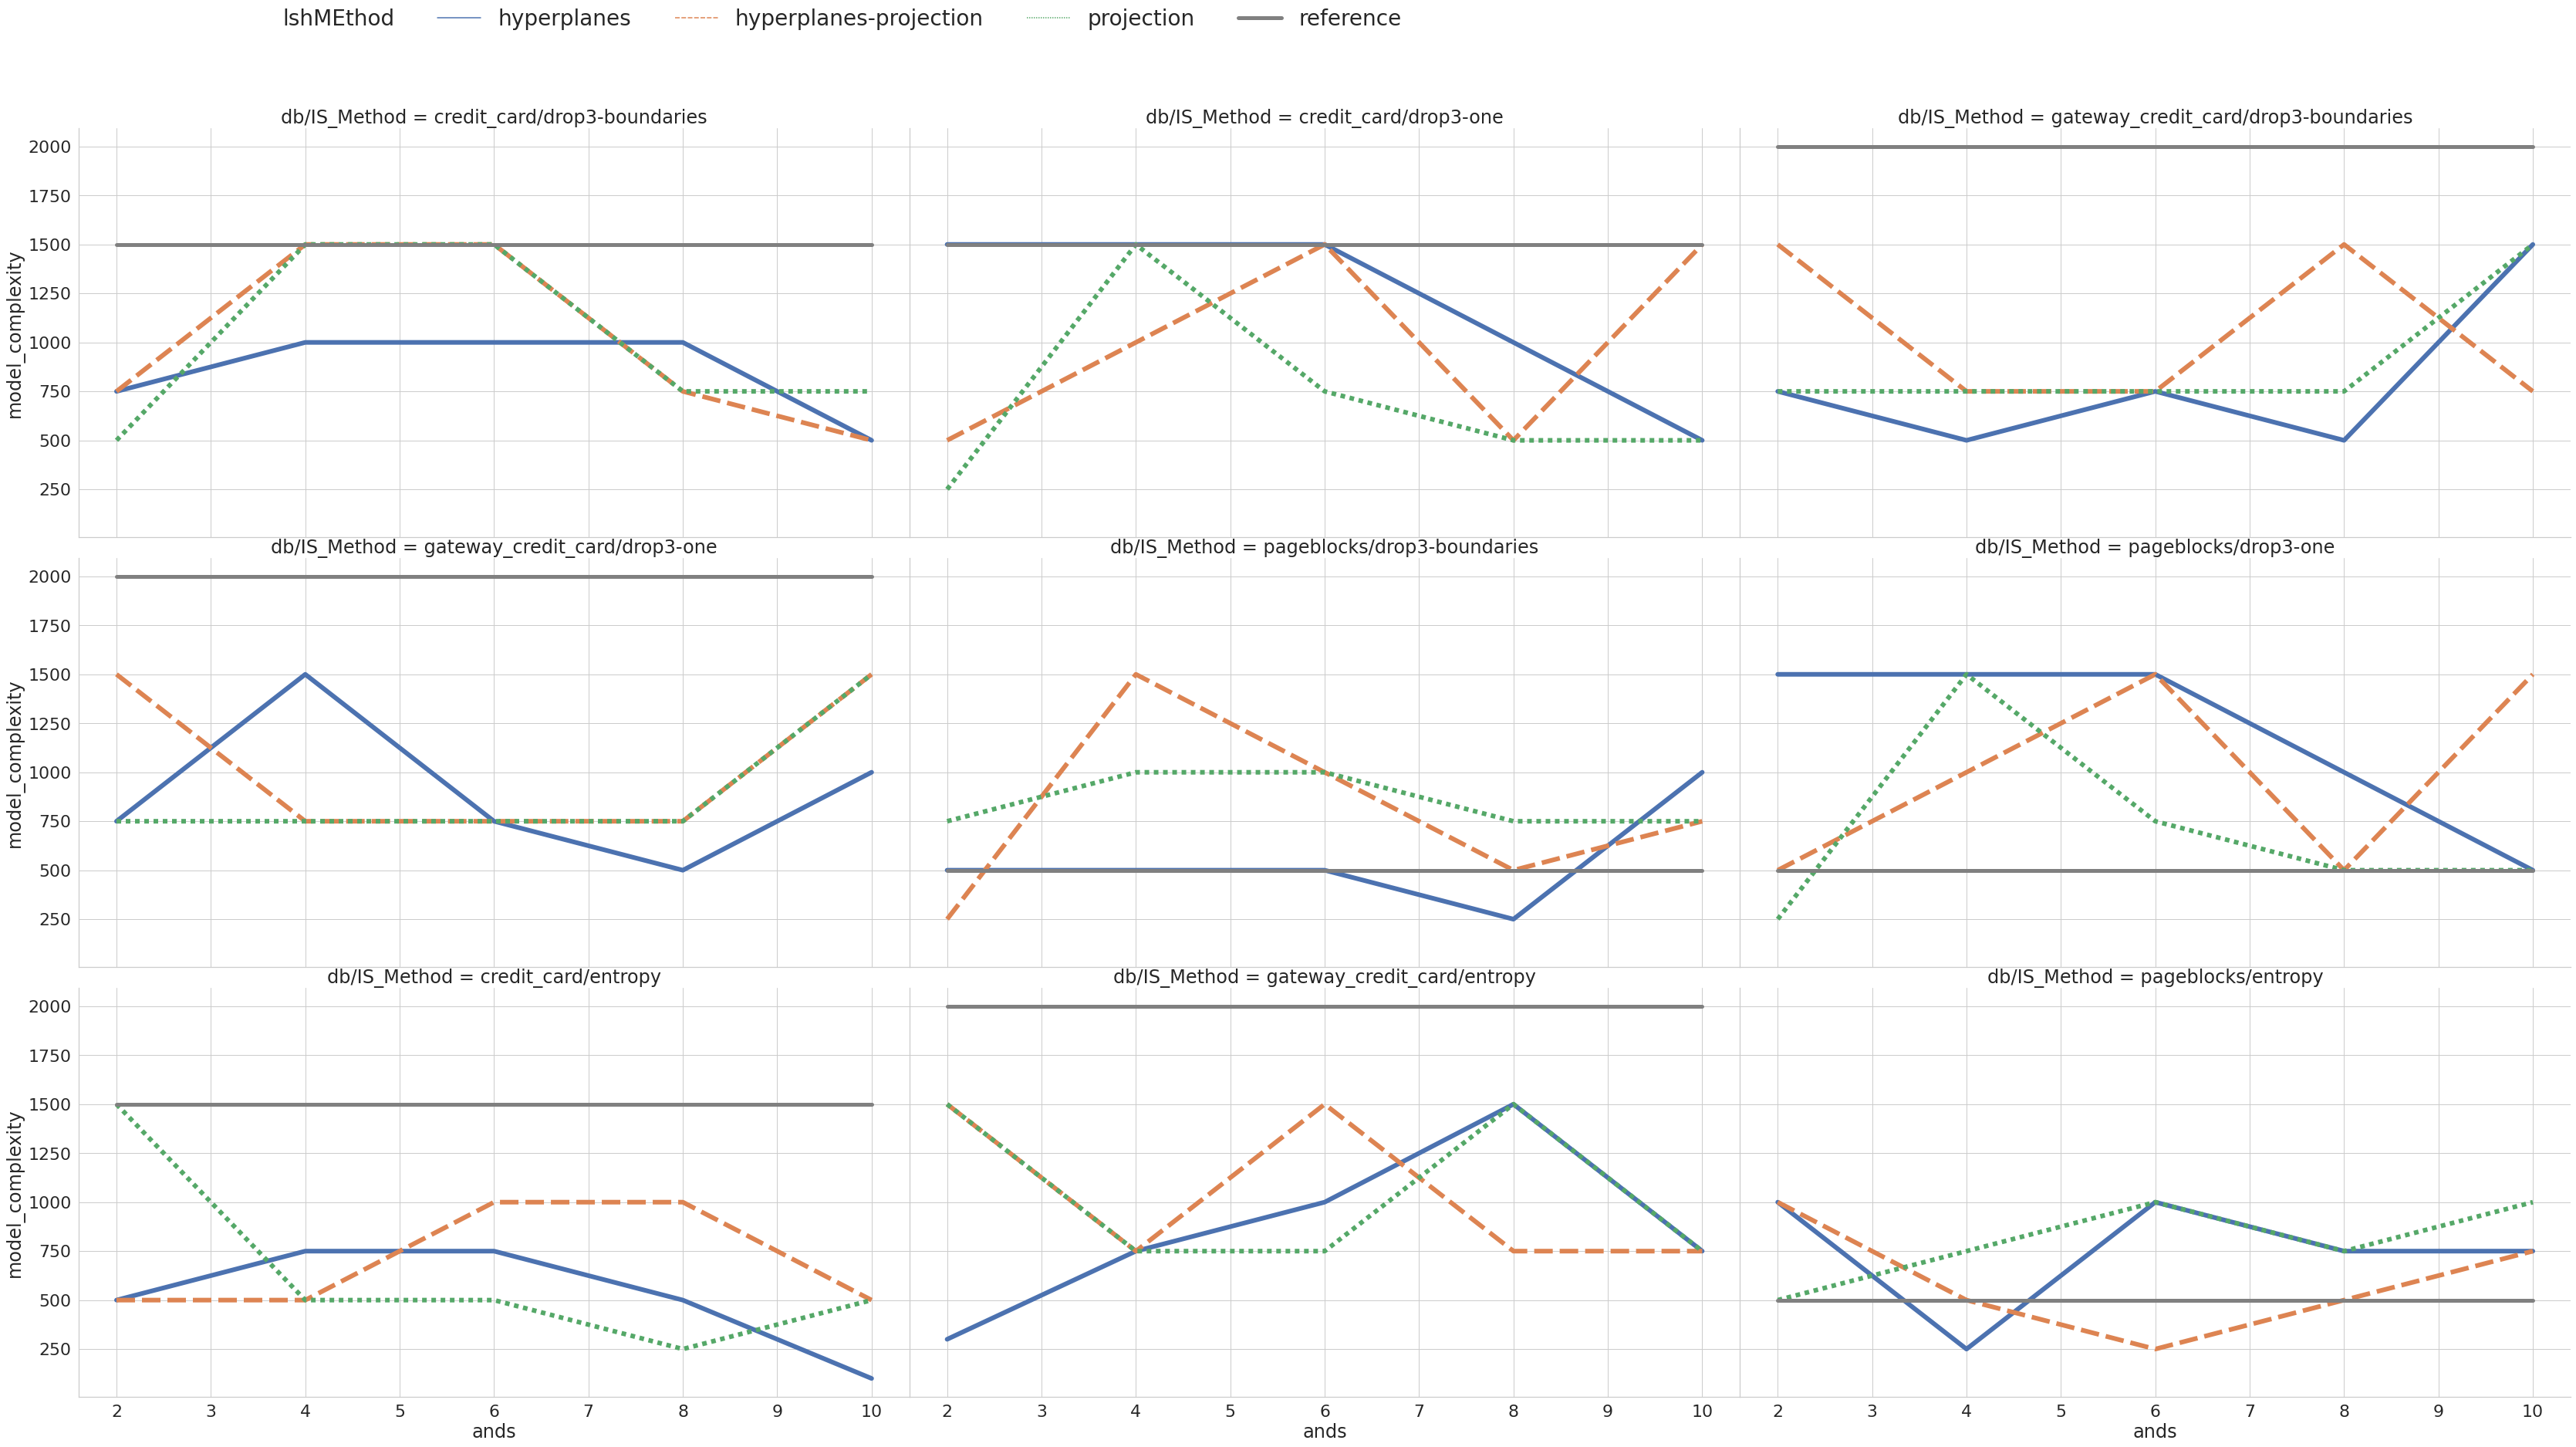

In [47]:
plot_9_results(df_toplot, best_no_is, measure= 'model_complexity', measure_for_best='Gmean')

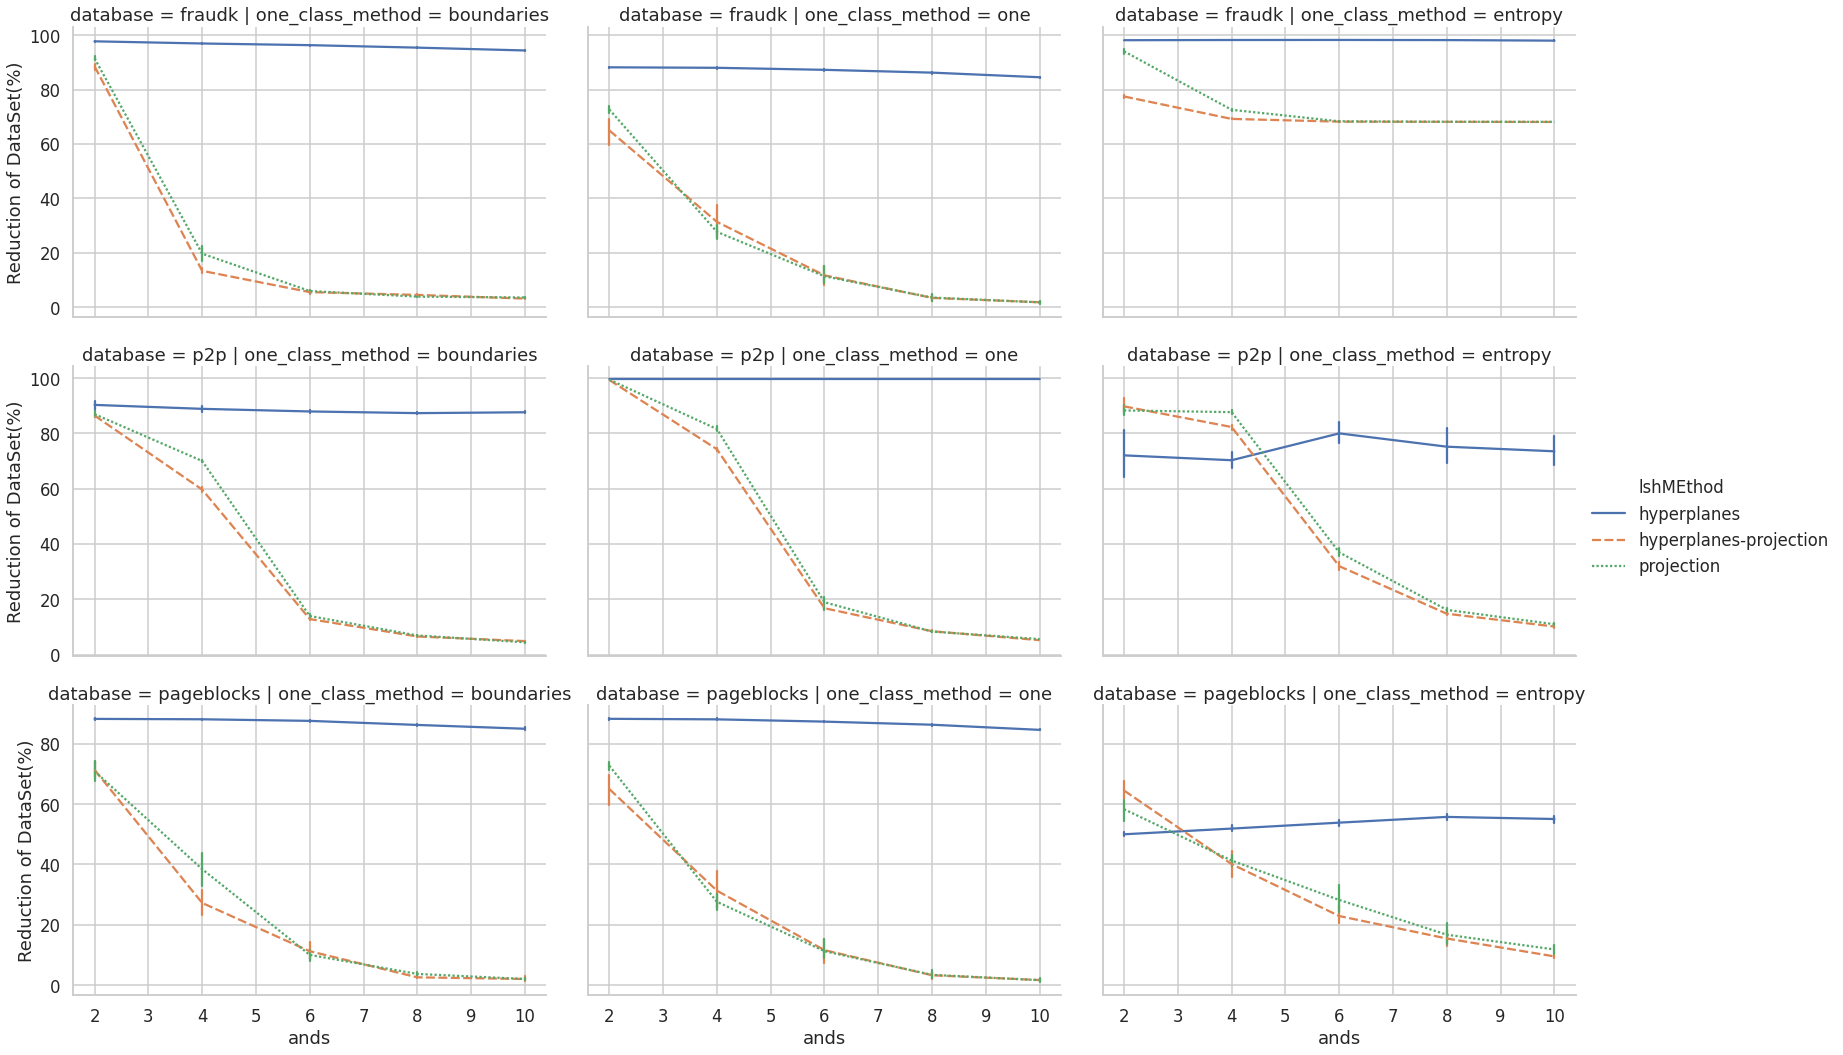

In [320]:
plot_9_results(results_dedup, cond, None, measure=  'Reduction of DataSet(%)', measure_for_best='Gmean')

In [418]:
plt.add_

'0.10.1'

# Table Generation

In [172]:
def to_mean_std_cell(df, cols_only_mean = ['model_complexity']):
    columns = list(df.columns)
    table = pd.DataFrame()
    idx = 0
    for c in range(int(len(columns)/2)):
        if columns[c+idx][0] not in cols_only_mean:
            table[columns[c+idx][0]] = df[columns[c+idx] ].astype('str') + " +- " +  df[columns[c+idx+1]].astype('str')
        else:
            table[columns[c+idx][0]] = df[columns[c+idx] ].astype('str')
        idx+=1
    return(table)

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

In [ ]:
order_cols = ['sensibility', 'specificity', 'F1', 'Gmean', 'balancedAcc', 
              'mcc','Reduction of DataSet(%)', 'model_complexity']

cols_to_ignore = ['timeIS', 'timeLSH', 'Total Time', 
                  'level_6', 'imbalance', 'trees','depth',
                  'tp', 'tn', 'fp', 'fn', 'precision', 'accuracy',
                  'wtdAcc', 'AreaROC', 'precision']

In [22]:
results_dedup = drop3_entropy.drop_duplicates(cols_to_dedup +[ 'one_class_method'])
cond= results_dedup.imbalance == True

In [151]:
to_table = (results_dedup[cond].groupby(factorsIS)
                .apply(lambda g : ut.get_best_for(g, measures, measure_sort = 'Gmean', factorsModel = factorsModel))
                .reset_index())
to_table = to_table[to_table.type=='test'].drop(cols_to_ignore, axis = 1)
to_table['isMethod'] = to_table['isMethod'] + "-" + to_table['one_class_method'] 
to_table= to_table.groupby(['database','lshMEthod', 'isMethod', 'ands']).agg(['mean', 'std']).round(2)
table = to_mean_std_cell(to_table)[order_cols]

In [163]:
factorsNOIS = ['database','lshMEthod', 'isMethod', 'ands',]
best_no_is_table = best_no_is.copy()
best_no_is_table['lshMEthod'] = 'NoIS'
best_no_is_table['isMethod'] = 'NoIS'
best_no_is_table['ands'] = 'NoIS'
table_reference =( best_no_is_table[best_no_is_table.type == 'test']
                  .drop(cols_to_ignore + ['level_1', 'k'], axis = 1, errors='ignore')
                  .groupby(factorsNOIS)
                  .agg(['mean', 'std'])
                  .round(2))
table_reference = to_mean_std_cell(table_reference)

In [173]:
def get_final_table(reference, is_table, db):
    db_table = pd.concat([reference.loc[[i for i in reference.index if db in i], :], 
                          is_table.loc[[i for i in is_table.index if db in i], :]])
    return(db_table.fillna("--"))

db = results_dedup.database.unique()
with pd.ExcelWriter('table.xlsx') as writer:
    get_final_table(table_reference, table, db[0]).style.apply(highlight_max, axis = 0).to_excel(writer, sheet_name=db[0])
    get_final_table(table_reference, table, db[1]).style.apply(highlight_max, axis = 0).to_excel(writer, sheet_name=db[1])
    get_final_table(table_reference, table, db[2]).style.apply(highlight_max, axis = 0).to_excel(writer, sheet_name=db[2])

# Hypothesis Testing

In [ ]:
from scipy.stats import wilcoxon
ref = best_no_is.loc[(best_no_is.database=='fraudk') & (best_no_is.type == 'test'), 'Gmean'].copy()
bounda1 = results_dedup.loc[(results_dedup.database=='fraudk') 
&  (results_dedup.type == 'test') 
& (results_dedup.one_class_method=='boundaries') 
& (results_dedup.lshMEthod == 'hyperplanes-projection')
&(results_dedup.ands==10), 'Gmean'].copy()
len(bounda1)
stat, p = wilcoxon(ref[0:45], bounda1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')